In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import transformers

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [4]:
!pip install transformers==4.35.2
!pip install datasets==2.14.6
!pip install accelerate==0.25.0
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 93.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

2025-11-05 11:08:09.077595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762340889.101381   11447 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762340889.108497   11447 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/meld-emotion-recognition/JSON files/JSON files/Updated CSV/train_sent_emo_cleaned.csv')

In [6]:
dff = df.drop(columns=['Sr No.','Dialogue_ID','Sentiment','Utterance_ID','Season','Episode','StartTime','EndTime'])

In [7]:
df.drop(columns=['Sr No.','Dialogue_ID','Sentiment','Utterance_ID','Season','Episode','StartTime','EndTime','Speaker'],inplace = True)

In [9]:
df.rename(columns={'Utterance': 'text', 'Emotion': 'emotion'},inplace=True)


In [10]:
df

,text,emotion
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9983,You or me?,neutral
9984,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9985,"You guys are messing with me, right?",surprise
9986,Yeah.,neutral


In [14]:
import re
import html
import pandas as pd

def clean_text(text):
    if pd.isna(text):
        return ""
    s = str(text)
    s = html.unescape(s)                 
    s = s.lower()                         # lowercase
    s = re.sub(r'http\S+',' ', s)        # remove URLs
    s = re.sub(r'@\w+',' ', s)           # remove @mentions
    s = re.sub(r'#',' ', s)              # drop # but keep text
    s = re.sub(r'[^a-z0-9\s]',' ', s)    # remove punctuation (keep alnum + spaces)
    s = re.sub(r'\s+',' ', s).strip()    # collapse whitespace
    return s

# Example usage:
# If you know the text column name, replace 'text_column' below:
# df['cleaned_text'] = df['text_column'].apply(clean_text)

# If you don't know the text column name and want to pick the first object/string column:
text_cols = df.select_dtypes(include=['object']).columns.tolist()
if not text_cols:
    raise ValueError("No object/string columns found in df to clean.")
text_col = text_cols[0]   # change index or choose column explicitly if needed
df['cleaned_text'] = df[text_col].apply(clean_text)


In [15]:
df.drop(columns=['text'],inplace=True)

In [16]:
df

,emotion,cleaned_text
0,neutral,also i was the point person on my company s tr...
1,neutral,you must ve had your hands full
2,neutral,that i did that i did
3,neutral,so let s talk a little bit about your duties
4,surprise,my duties all right
...,...,...
9983,neutral,you or me
9984,neutral,i got it uh joey women don t have adam s apples
9985,surprise,you guys are messing with me right
9986,neutral,yeah


In [17]:
df.rename(columns={'cleaned_text':'text'},inplace=True)

In [18]:
df

,emotion,text
0,neutral,also i was the point person on my company s tr...
1,neutral,you must ve had your hands full
2,neutral,that i did that i did
3,neutral,so let s talk a little bit about your duties
4,surprise,my duties all right
...,...,...
9983,neutral,you or me
9984,neutral,i got it uh joey women don t have adam s apples
9985,surprise,you guys are messing with me right
9986,neutral,yeah


In [11]:
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nEmotion distribution:")
print(df['emotion'].value_counts())

Dataset shape: (9988, 2)

First few rows:
                                                text   emotion
0  also I was the point person on my companys tr...   neutral
1                   You mustve had your hands full.   neutral
2                            That I did. That I did.   neutral
3      So lets talk a little bit about your duties.   neutral
4                             My duties?  All right.  surprise

Emotion distribution:
emotion
neutral     4709
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64


In [12]:
emotions = df['emotion'].unique()
label2id = {label: i for i, label in enumerate(emotions)}
id2label = {i: label for label, i in label2id.items()}

print(f"\nLabel mappings:")
print(f"label2id: {label2id}")


Label mappings:
label2id: {'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}


In [13]:
df['label'] = df['emotion'].map(label2id)

In [74]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [75]:
def smart_balance(df, target_size=1200):
    """
    Balance the dataset using smart undersampling and oversampling
    
    Parameters:
    -----------
    df : DataFrame
        Your dataframe with 'text' and 'Emotion' columns
    target_size : int
        Target number of samples per emotion (default: 1200)
    
    Returns:
    --------
    df_balanced : DataFrame
        Balanced dataframe where each emotion has exactly target_size samples
    """
    
    print("=" * 60)
    print("ORIGINAL DISTRIBUTION:")
    print("=" * 60)
    print(df['emotion'].value_counts().sort_index())
    print(f"\nTotal samples: {len(df)}")
    
    balanced_dfs = []
    
    # Process each emotion separately
    for emotion in df['emotion'].unique():
        # Get all samples for this emotion
        df_emotion = df[df['emotion'] == emotion]
        current_size = len(df_emotion)
        
        # Resample to target_size
        # replace=True means we can pick the same sample multiple times (oversampling)
        # replace=False means we pick without replacement (undersampling)
        df_resampled = resample(
            df_emotion,
            replace=(current_size < target_size),  # Oversample if too small
            n_samples=target_size,
            random_state=42
        )
        
        # Log what happened
        if current_size > target_size:
            print(f"✓ {emotion:10s}: {current_size:5d} → {target_size} (UNDERSAMPLED)")
        elif current_size < target_size:
            print(f"↑ {emotion:10s}: {current_size:5d} → {target_size} (OVERSAMPLED)")
        else:
            print(f"= {emotion:10s}: {current_size:5d} → {target_size} (NO CHANGE)")
        
        balanced_dfs.append(df_resampled)
    
    # Combine all balanced emotions
    df_balanced = pd.concat(balanced_dfs, ignore_index=True)
    
    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\n" + "=" * 60)
    print("BALANCED DISTRIBUTION:")
    print("=" * 60)
    print(df_balanced['emotion'].value_counts().sort_index())
    print(f"\nTotal samples: {len(df_balanced)}")
    
    return df_balanced

In [76]:
def visualize_balance(df_original, df_balanced):
    """
    Visualize the distribution before and after balancing
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Original distribution
    emotion_counts_original = df_original['emotion'].value_counts()
    ax1.bar(emotion_counts_original.index, emotion_counts_original.values, color='skyblue')
    ax1.set_title('Original Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotions', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Balanced distribution
    emotion_counts_balanced = df_balanced['emotion'].value_counts()
    ax2.bar(emotion_counts_balanced.index, emotion_counts_balanced.values, color='lightgreen')
    ax2.set_title('Balanced Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Emotions', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [77]:
df_balanced = smart_balance(df, target_size=1200)

ORIGINAL DISTRIBUTION:
emotion
anger       1109
disgust      271
fear         268
joy         1743
neutral     4709
sadness      683
surprise    1205
Name: count, dtype: int64

Total samples: 9988
✓ neutral   :  4709 → 1200 (UNDERSAMPLED)
✓ surprise  :  1205 → 1200 (UNDERSAMPLED)
↑ fear      :   268 → 1200 (OVERSAMPLED)
↑ sadness   :   683 → 1200 (OVERSAMPLED)
✓ joy       :  1743 → 1200 (UNDERSAMPLED)
↑ disgust   :   271 → 1200 (OVERSAMPLED)
↑ anger     :  1109 → 1200 (OVERSAMPLED)

BALANCED DISTRIBUTION:
emotion
anger       1200
disgust     1200
fear        1200
joy         1200
neutral     1200
sadness     1200
surprise    1200
Name: count, dtype: int64

Total samples: 8400


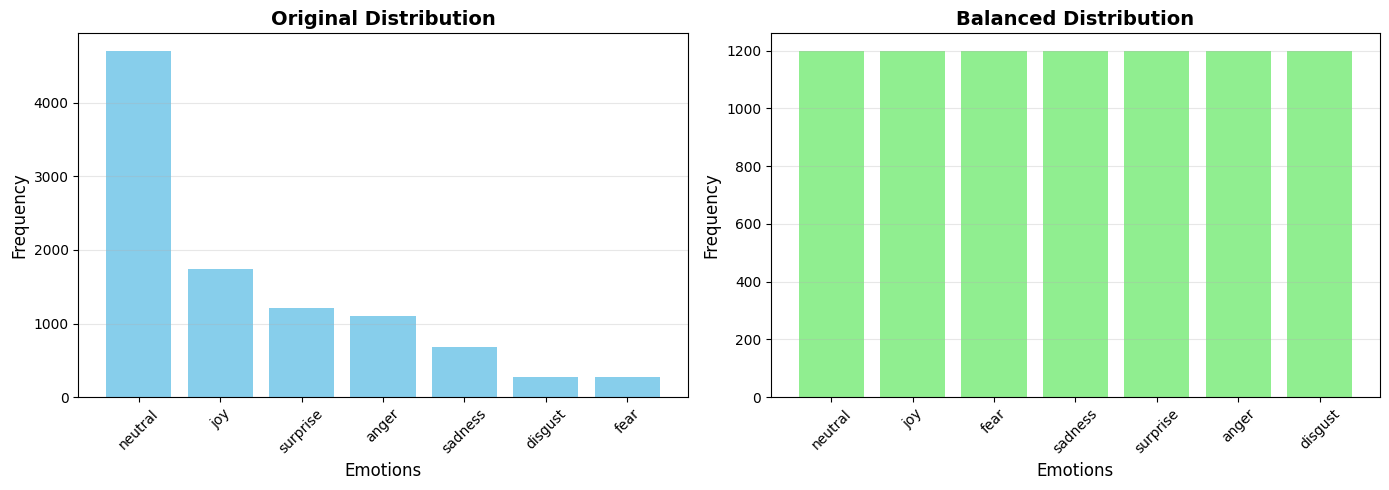

In [78]:
visualize_balance(df, df_balanced)

In [22]:
train_df, temp_df = train_test_split(
    df_balanced, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_balanced['label']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['label']
)

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 5880
Validation size: 1260
Test size: 1260


In [24]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


model_name_2 = "microsoft/deberta-v3-base"

# Tokenizer
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)



In [25]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

In [26]:
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/5880 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

In [46]:
from transformers import BertConfig, BertForSequenceClassification

# 1. Load and modify config
config = BertConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.3           # Default is 0.1
config.attention_probs_dropout_prob = 0.3  # Default is 0.1
config.num_labels = len(label2id)
config.id2label = id2label
config.label2id = label2id

# 2. Load model with modified config
model = BertForSequenceClassification.from_pretrained(
    model_name,
    config=config
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
    }

In [61]:
training_args = TrainingArguments(
    output_dir='./results_5',
    num_train_epochs=60,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.1,           # INCREASED: From 0.01 to 0.1 (stronger regularization)
    learning_rate=2e-5,         # ADDED: Lower learning rate (default is often 5e-5, which can be too high)
    logging_dir='./logs_5',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=1,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
    disable_tqdm=False,
    logging_first_step=True,
)


In [47]:
# 1. Freeze the entire BERT base model first
for param in model.bert.parameters():
    param.requires_grad = False

# 2. Unfreeze the last 2 layers of the BERT encoder
# (BERT-base has 12 layers, so this unfreezes layers 10 and 11)
for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

# 3. Ensure the classifier head is definitely trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# Optional: Verify reduction in trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Training {trainable_params:,} out of {all_params:,} parameters")

Training 14,181,127 out of 109,487,623 parameters


In [30]:
from transformers import EarlyStoppingCallback

In [48]:
trainer = Trainer(
    model=model,                  # Uses your new BERT model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [34]:
trainer_2 = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [59]:
trainer_b = Trainer(
    model=model,                  # Uses your new BERT model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
)

In [62]:
trainer_b1 = Trainer(
    model=model,                  # Uses your new BERT model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
)

In [63]:
train_result_balanced_b1 = trainer_b1.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.149200,1.223453,0.585714
2,1.166900,1.214070,0.603175
3,0.971000,1.219052,0.592857
4,0.988300,1.203356,0.606349
5,0.872600,1.201552,0.601587
6,0.836700,1.219178,0.611111
7,0.909800,1.204456,0.623810
8,0.927000,1.181233,0.627778
9,0.932900,1.223393,0.616667
10,0.969600,1.180801,0.627778


In [56]:
train_result_balanced_b = trainer_b.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.534700,1.495000,0.450794
2,1.563900,1.481691,0.457937
3,1.400500,1.469652,0.465873
4,1.479400,1.441874,0.477778
5,1.347100,1.420006,0.496032
6,1.262400,1.411135,0.501587
7,1.347000,1.389101,0.505556
8,1.369500,1.359812,0.526190
9,1.346700,1.369967,0.526984
10,1.378500,1.338501,0.538889


In [51]:
train_result_balanced_2 = trainer_b.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.982400,1.960213,0.152381
2,1.939600,1.900822,0.202381
3,1.805400,1.775326,0.307937
4,1.802500,1.669807,0.384127
5,1.653400,1.593148,0.403175
6,1.584700,1.551861,0.422222
7,1.580100,1.529923,0.428571
8,1.570200,1.512443,0.439683
9,1.565000,1.503943,0.439683
10,1.544300,1.501767,0.447619


Checkpoint destination directory ./results_3/checkpoint-184 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_3/checkpoint-1472 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [66]:
print("\n" + "="*50)
print("Evaluating on Test Set...")
print("="*50 + "\n")

predictions = trainer_b1.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_df['label'].values



Evaluating on Test Set...



In [68]:
# Evaluate on the training dataset
train_metrics = trainer.evaluate(eval_dataset=train_dataset, metric_key_prefix="train")

print("Training Metrics:", train_metrics)

early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


Training Metrics: {'train_loss': 0.5060234665870667, 'train_accuracy': 0.8302721088435374, 'train_runtime': 23.9842, 'train_samples_per_second': 245.161, 'train_steps_per_second': 3.836}


In [67]:
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(len(id2label))]
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.6714

Classification Report:
              precision    recall  f1-score   support

     neutral       0.58      0.56      0.57       180
    surprise       0.64      0.69      0.66       180
        fear       0.77      0.91      0.83       180
     sadness       0.62      0.62      0.62       180
         joy       0.60      0.61      0.60       180
     disgust       0.83      0.85      0.84       180
       anger       0.63      0.47      0.54       180

    accuracy                           0.67      1260
   macro avg       0.67      0.67      0.67      1260
weighted avg       0.67      0.67      0.67      1260


Confusion Matrix:
[[101  16  15  19  14   5  10]
 [ 18 124   3   7  17   4   7]
 [  7   3 164   0   3   2   1]
 [ 16  16  10 111  11   5  11]
 [ 16  13  11  16 109   4  11]
 [  2   4   0   9   3 153   9]
 [ 15  19  11  16  24  11  84]]


In [35]:
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(len(id2label))]
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.7484

Classification Report:
              precision    recall  f1-score   support

     neutral       0.63      0.56      0.59       180
    surprise       0.72      0.69      0.70       180
        fear       0.87      0.96      0.91       180
     sadness       0.77      0.74      0.76       180
         joy       0.63      0.59      0.61       180
     disgust       0.90      0.94      0.92       180
       anger       0.68      0.76      0.71       180

    accuracy                           0.75      1260
   macro avg       0.74      0.75      0.74      1260
weighted avg       0.74      0.75      0.74      1260


Confusion Matrix:
[[100  12  11  15  19   6  17]
 [  8 124   1   7  25   3  12]
 [  1   3 172   3   1   0   0]
 [ 10  10   8 134   5   1  12]
 [ 29  10   5   6 107   4  19]
 [  1   0   0   2   2 170   5]
 [  9  13   1   6  10   5 136]]


In [81]:
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(len(id2label))]
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.5370

Classification Report:
              precision    recall  f1-score   support

     neutral       0.63      0.73      0.68       707
    surprise       0.51      0.48      0.49       181
        fear       0.37      0.17      0.24        40
     sadness       0.35      0.32      0.34       102
         joy       0.48      0.43      0.45       262
     disgust       0.38      0.23      0.28        40
       anger       0.29      0.25      0.27       167

    accuracy                           0.54      1499
   macro avg       0.43      0.37      0.39      1499
weighted avg       0.52      0.54      0.52      1499


Confusion Matrix:
[[516  39   3  28  65   6  50]
 [ 62  86   2   5  13   2  11]
 [ 12   7   7   2   8   0   4]
 [ 32   6   3  33  12   3  13]
 [116  11   2   8 112   0  13]
 [ 10   2   0   6   1   9  12]
 [ 69  19   2  11  20   4  42]]


In [37]:
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}\n")
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(len(id2label))]
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Test Accuracy: 0.5497

Classification Report:
              precision    recall  f1-score   support

     neutral       0.56      0.91      0.69       707
    surprise       0.47      0.51      0.49       181
        fear       0.00      0.00      0.00        40
     sadness       0.44      0.11      0.17       102
         joy       0.69      0.27      0.39       262
     disgust       0.00      0.00      0.00        40
       anger       0.23      0.04      0.07       167

    accuracy                           0.55      1499
   macro avg       0.34      0.26      0.26      1499
weighted avg       0.50      0.55      0.47      1499


Confusion Matrix:
[[642  33   0   7  20   0   5]
 [ 79  92   0   1   7   0   2]
 [ 31   7   0   1   1   0   0]
 [ 71  14   0  11   1   0   5]
 [163  22   0   1  72   0   4]
 [ 27   4   0   1   1   0   7]
 [129  25   0   3   3   0   7]]


In [71]:
def predict_emotion(text):
    """Predict emotion for a given text"""
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=128
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1).item()
    confidence = predictions[0][predicted_class].item()
    
    return id2label[predicted_class], confidence

In [39]:
# Test the model
test_texts = [
    "I am so happy today!",
    "This is really frustrating.",
    "I'm scared about the future.",
    "Fuck off",
    "i am frightened",
    "I will throw the rod at you!!",
    "How are you?",
    "I am not able to speak now!",
    "How a person can do this thing??",
    "I got placed today withg good package"
]

print("\n" + "="*50)
print("Testing Model Predictions:")
print("="*50)
for text in test_texts:
    emotion, confidence = predict_emotion(text)
    print(f"\nText: {text}")
    print(f"Predicted Emotion: {emotion}")
    print(f"Confidence: {confidence:.4f}")


Testing Model Predictions:

Text: I am so happy today!
Predicted Emotion: joy
Confidence: 0.9989

Text: This is really frustrating.
Predicted Emotion: sadness
Confidence: 0.8906

Text: I'm scared about the future.
Predicted Emotion: sadness
Confidence: 0.9981

Text: Fuck off
Predicted Emotion: disgust
Confidence: 0.5861

Text: i am frightened
Predicted Emotion: fear
Confidence: 0.9958

Text: I will throw the rod at you!!
Predicted Emotion: anger
Confidence: 0.9897

Text: How are you?
Predicted Emotion: neutral
Confidence: 0.9854

Text: I am not able to speak now!
Predicted Emotion: fear
Confidence: 0.9803

Text: How a person can do this thing??
Predicted Emotion: surprise
Confidence: 0.9987

Text: I got placed today withg good package
Predicted Emotion: joy
Confidence: 0.9973


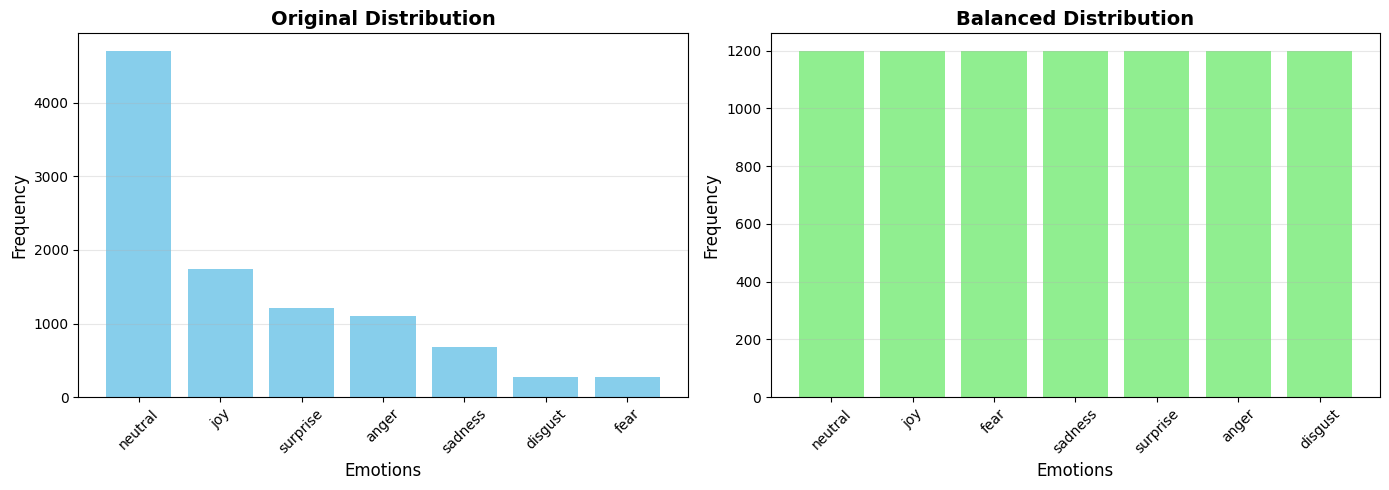